## What should be presented in the case study:

#### 1. Degree (strength) distribution


#### 2. Two of the following characteristics:

    2.1 Average path length

    2.2 Clustering coefficient

    2.3 Small-worldness


 #### 3. At least one of centrality measures: 

    3.1 Degree centrality￼

    3.2 Closeness centrality￼

    3.3 Betweenness

    3.4 Prestige

    3.5 Decay centrality

#### 4. You need to consider at least 2 networks

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy.stats import kstest, powerlaw
from functools import partial

In [2]:
options = {
    'node_color': 'lavender',
    'node_size': 500,
    'width': .3,
    'arrowstyle': '-|>',
    'arrowsize': 10,
    'with_labels':True
}

# Data loading

In [3]:
path = "./data/"
fileName2019 = "EU_routes_2019.csv.gz"
fileName2022 = "EU_routes_2022.csv.gz"
fileAirports = "airports_clean.csv"
routes2019 = pd.read_csv(path + fileName2019)
routes2022 = pd.read_csv(path + fileName2022)
airports = pd.read_csv(path+fileAirports)
routes = {"2019": routes2019, "2022": routes2022}
years = ["2019", "2022"]

In [4]:
#create directed and undirected network object 
G2019_directed=nx.from_pandas_edgelist(routes2019, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2019_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G2022_directed=nx.from_pandas_edgelist(routes2022, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G_directed = {"2019": G2019_directed, "2022": G2022_directed}
G_undirected = {"2019": G2019_undirected, "2022": G2022_undirected}
# Returns the biggest giant strongly connected component in the network
G2019_directed_connected = G2019_directed.subgraph(sorted(nx.strongly_connected_components(G2019_directed), key = len, reverse = True)[0])
G2022_directed_connected = G2022_directed.subgraph(sorted(nx.strongly_connected_components(G2022_directed), key = len, reverse = True)[0])
G_directed_connected = {"2019": G2019_directed_connected, "2022": G2022_directed_connected}

# Data exploration

Using opensky-network.org's Covid-19 Dataset showing air-traffic for January 2019 and Oktober 2022

Considering Europe and excluding all flights that only appear once a month or take off and land on the same airfield to ensure data quality

We use the unique callsigns (indicating different carriers) of the flights as weights for multiple appearances

In [129]:
# Using opensky-network.org's Covid-19 Dataset showing air-traffic for January 2019 and Oktober 2022
# Considering Europe and excluding all flights that only appear once a month
# Number of unique origin_IATA_IATAs
for year in years:
    print(f"{year:4}: {routes[year].origin_IATA.nunique():3} origins and {routes[year].destination_IATA.nunique():3} destinations with {routes[year].weight.count()} total connections that appeared on more than one day in the month")

2019: 368 origins and 405 destinations with 7952 total connections that appeared on more than one day in the month
2022: 489 origins and 527 destinations with 13369 total connections that appeared on more than one day in the month


In [10]:
for year in years:
    print(f"{year:4}: Number of nodes: {G_directed[year].number_of_nodes()}")

2019: Number of nodes: 428
2022: Number of nodes: 546


# Basic Network Metrics and Plots

In [8]:
#Produce adjecancy matrices for 2022 and 2022 for the directed network
adj2019 = nx.to_pandas_adjacency(G2019_directed, dtype = int)
adj2022 = nx.to_pandas_adjacency(G2022_directed, dtype = int)
adj2019.head()

,AAL,AAR,AGP,AMS,BRE,CPH,GOT,LEY,ODE,OSL,...,SPM,SQQ,ODH,KDL,LME,URE,WVN,AGE,XCR,KOQ
AAL,0,2,1,3,2,28,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
AAR,0,0,0,3,0,13,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
AGP,1,0,0,9,2,8,3,0,0,3,...,0,0,0,0,0,0,0,0,0,0
AMS,4,0,8,0,4,19,5,0,0,9,...,0,0,0,0,0,0,0,0,0,0
BRE,0,0,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


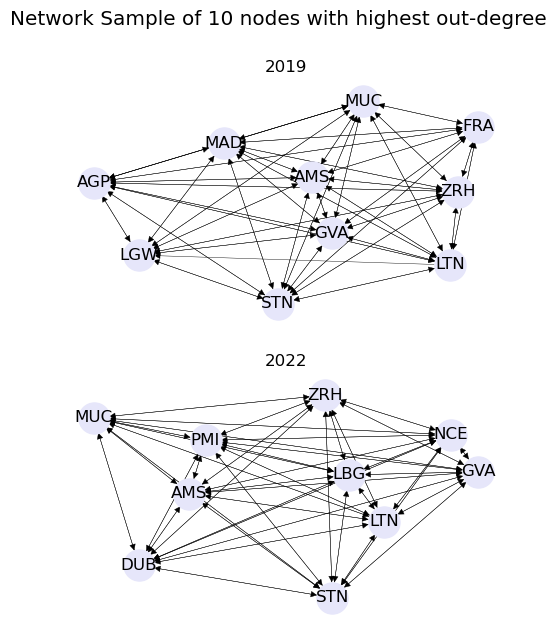

In [55]:
## Draw a sample network with the n nodes with the highest out degree

#Choose Number of nodes
n = 10
#Choose Graph to draw from
graph = G_directed

fig, ax = plt.subplots(len(years), figsize = (6,7))
fig.suptitle(f"Network Sample of {n} nodes with highest out-degree", fontsize = "x-large")
i = 0
#Create and draw subgraph with n nodes
for year in years:
    degree = sorted(graph[year].out_degree, key = lambda x: x[1], reverse = True)[0:n]
    nodes = [node for node,_ in degree]
    G_sample = graph[year].subgraph(nodes)
    nx.draw(G_sample, ax = ax[i], **options)
    ax[i].set_title(year)
    i+=1

## Degree

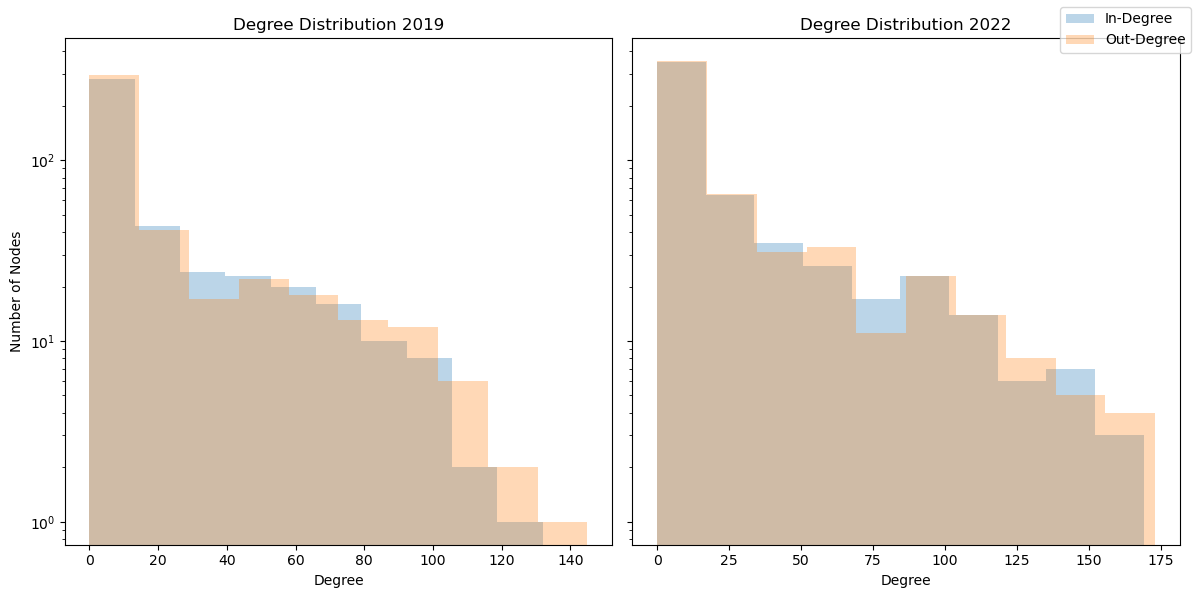

In [14]:
#caluculate in degrees 
in_degree2019 = dict(G2019_directed.in_degree)
in_degree2022 = dict(G2022_directed.in_degree)
#out degree
out_degree2019 = dict(G2019_directed.out_degree)
out_degree2022 = dict(G2022_directed.out_degree)

fig, ax = plt.subplots(1,2, figsize = (12,6), sharey = True)

ax[0].hist(in_degree2019.values(), alpha=0.3, log = True, label = 'In-Degree')
ax[0].hist(out_degree2019.values(), alpha=0.3, log = True, label = 'Out-Degree')
ax[0].set_title('Degree Distribution 2019')

ax[1].hist(in_degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
ax[1].hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
ax[1].set_title('Degree Distribution 2022')

for i in [0,1]:
    ax[i].set_xlabel("Degree")

ax[0].set_ylabel("Number of Nodes")


fig.legend(["In-Degree", "Out-Degree"])
fig.tight_layout()

In [136]:
columns = pd.MultiIndex.from_product([["In-Degree", "Out-Degree"], years], names = ["measure", "year"])
degrees = pd.concat([pd.Series(in_degree2019.values()),
                    pd.Series(in_degree2022.values()), 
                    pd.Series(out_degree2019.values()), 
                    pd.Series(out_degree2022.values())], keys = columns, axis= 1)
degrees.describe(percentiles=[.25,.5,.6,.7,.8,.9])

measure   In-Degree              Out-Degree            
year           2019        2022        2019        2022
count    428.000000  546.000000  428.000000  546.000000
mean      18.579439   24.485348   18.579439   24.485348
std       26.397001   34.758944   28.087864   35.844885
min        0.000000    0.000000    0.000000    0.000000
25%        2.000000    2.000000    1.000000    2.000000
50%        5.000000    8.000000    5.000000    7.000000
60%        9.000000   13.000000    8.200000   12.000000
70%       17.000000   23.000000   15.000000   24.000000
80%       35.600000   44.000000   33.600000   44.000000
90%       59.200000   81.500000   62.000000   85.500000
max      132.000000  169.000000  145.000000  173.000000

Mean is way higher than median --> there is some highly connected nodes --> hubs

# ADD BERLIN!

In [6]:
#cannot confirm a powerlaw in degree distribution based on the p-value
in_degree2019_list = list(dict(in_degree2019).values())
fit = powerlaw.fit(in_degree2019_list)
a, loc, scale  = fit
kstest(in_degree2019_list, partial(powerlaw.cdf, a=a, loc=loc, scale=scale), alternative='two-sided')

KstestResult(statistic=0.22263641515895918, pvalue=4.074513645640479e-19)

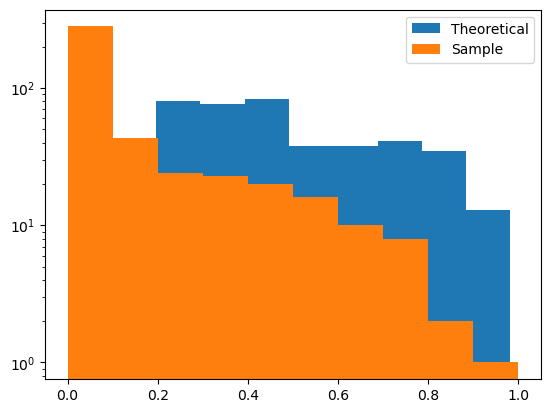

In [57]:
x_ = np.sort(powerlaw.cdf(in_degree2019_list, a=a, loc=loc, scale=scale))
x = np.sort(in_degree2019_list)/np.max(in_degree2019_list)

plt.hist(x_, label = 'Theoretical')
plt.hist(x, label = 'Sample')
plt.yscale("log")
plt.legend()

In [38]:
len(np.sort(in_degree2019_list))

428

In [76]:
height, x = np.histogram(powerlaw.cdf(in_degree2019_list, a=a, loc=loc, scale=scale))
print(height, x)

[23  0 81 76 83 38 38 41 35 13] [1.36724185e-07 9.82092106e-02 1.96418284e-01 2.94627358e-01
 3.92836432e-01 4.91045506e-01 5.89254580e-01 6.87463654e-01
 7.85672728e-01 8.83881801e-01 9.82090875e-01]


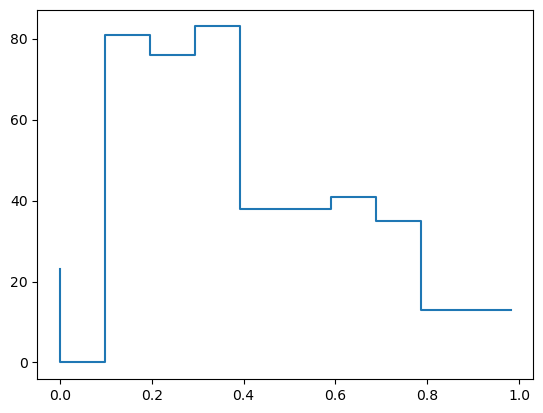

In [78]:
height = np.append(height, height[::-1][0])
plt.plot(x, height, drawstyle = "steps")

In [68]:
height[::-1][0]

13

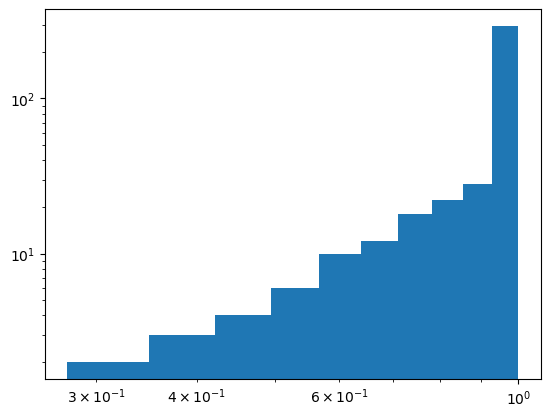

In [49]:
x = np.arange(1,400)
plt.hist(np.sort(powerlaw.cdf(x, a=a, loc=loc, scale=scale)))
plt.yscale("log")
plt.xscale("log")


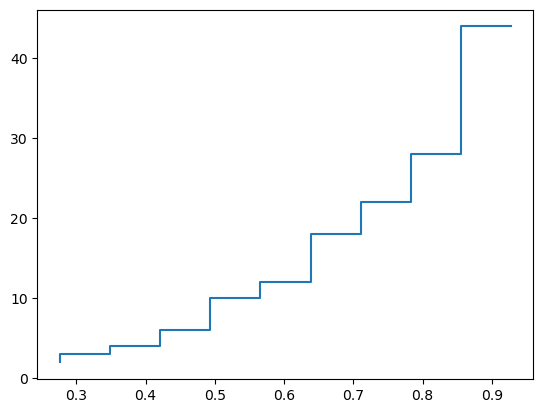

In [94]:
y, x = np.histogram(powerlaw.cdf(np.arange(1,150), a=a, loc=loc, scale=scale))
plt.step(x[:len(y)], y, label = "Distribution")

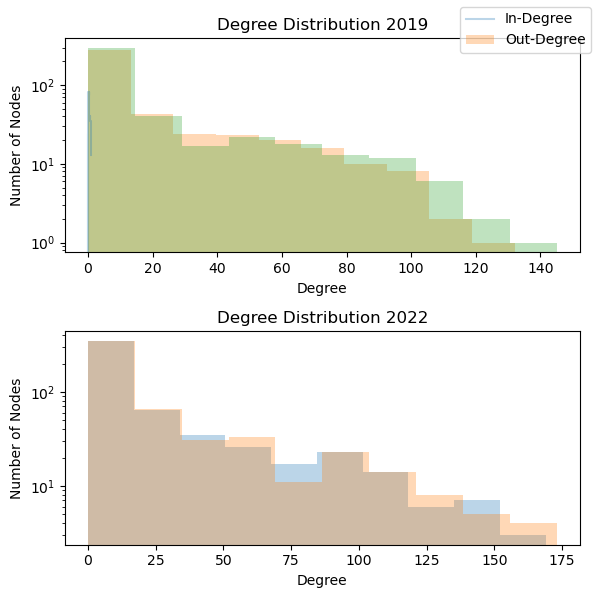

In [89]:
fig, ax = plt.subplots(2,1, figsize = (6,6))

ax[0].hist(in_degree2019.values(), alpha=0.3, log = True, label = 'In-Degree')
ax[0].hist(out_degree2019.values(), alpha=0.3, log = True, label = 'Out-Degree')
ax[0].set_title('Degree Distribution 2019')

ax[1].hist(in_degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
ax[1].hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
ax[1].set_title('Degree Distribution 2022')

for i in [0,1]:
    ax[i].set_xlabel("Degree")
    ax[i].set_ylabel("Number of Nodes")


fig.legend(["In-Degree", "Out-Degree"])
fig.tight_layout()

## Strength

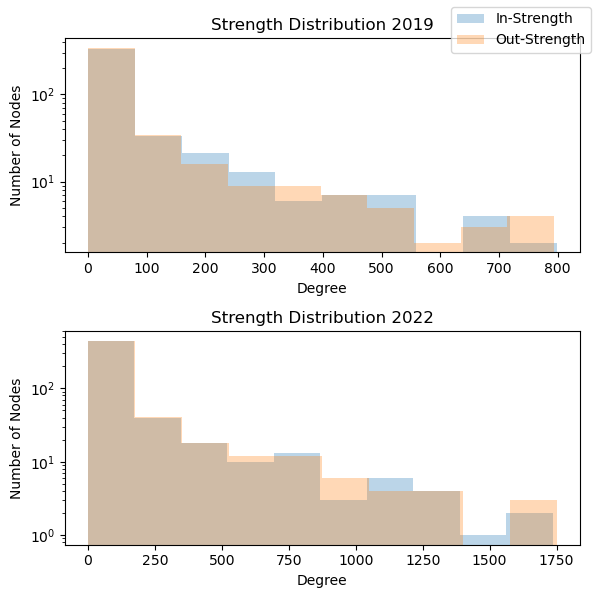

In [108]:
#strength distribution
in_strength2019 = dict(G2019_directed.in_degree(weight = 'weight'))
out_strength2019 = dict(G2019_directed.out_degree(weight = 'weight'))
in_strength2022 = dict(G2022_directed.in_degree(weight = 'weight'))
out_strength2022 = dict(G2022_directed.out_degree(weight = 'weight'))

fig, ax = plt.subplots(2,1, figsize = (6,6))

ax[0].hist(in_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
ax[0].hist(out_strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
ax[0].set_title('Strength Distribution 2019')

ax[1].hist(in_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
ax[1].hist(out_strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'Out-Strength')
ax[1].set_title('Strength Distribution 2022')

for i in [0,1]:
    ax[i].set_xlabel("Degree")
    ax[i].set_ylabel("Number of Nodes")

fig.legend(["In-Strength", "Out-Strength"])
fig.tight_layout()


In [91]:
max_strength = max(out_strength2019, key=out_strength2019.get)
print(f"Max Out-Strength 2019 is at {max_strength} with {out_strength2019[max_strength]}.")

Max Out-Strength 2019 is at MUC with 793.


In [92]:
max_strength = max(in_strength2019, key=in_strength2019.get)
print(f"Max In-Strength 2019 is at {max_strength} with {in_strength2019[max_strength]}.")

Max In-Strength 2019 is at MUC with 798.


In [93]:
max_strength = max(out_strength2022, key=out_strength2022.get)
print(f"Max Out-Strength 2022 is at {max_strength} with {out_strength2022[max_strength]}.")

Max Out-Strength 2022 is at PMI with 1750.


In [94]:
max_strength = max(in_strength2022, key=in_strength2022.get)
print(f"Max In-Strength 2022 is at {max_strength} with {in_strength2022[max_strength]}.")

Max In-Strength 2022 is at PMI with 1736.


## Distance measures

In [97]:
from networkx.algorithms.distance_measures import diameter
from networkx import average_shortest_path_length

In [40]:
G2022_directed_connected.number_of_nodes()

571

In [98]:
#Calculate the diameter: (For which network it should be done???!!)
for year in years:
    print(f"Diameter of european flight network {year}: {diameter(G_directed_connected[year])}")


Diameter of european flight network 2019: 7
Diameter of european flight network 2022: 6


In [101]:
#Calculate the diameter (-||-)
for year in years:
    print(f"Average shortest path length of european flight network {year}: {average_shortest_path_length(G_directed_connected[year]):.4f}")

Average shortest path length of european flight network 2019: 2.5469
Average shortest path length of european flight network 2022: 2.5474


## Centrality

In [25]:
from collections import defaultdict

In [22]:
#join SXF and BER into one line for plotting and comparisson
def get_berlin(df):
    ber = pd.DataFrame(df.loc[["SXF", "BER"],:].sum().rename("BER/SXF")).T
    df = pd.concat([df, ber]).drop(["BER", "SXF"], axis = 0)
    return df

In [26]:
#create a nested dictionary for centrality measures and years
centrality_measures = {"degree_centrality": nx.centrality.degree_centrality, #how connected the node is
                        "betweenness_centrality": nx.centrality.betweenness_centrality, #how important the node is in terms of connecting other nodes
                        "closeness_centrality": nx.centrality.closeness_centrality} #how easily a node can reach other nodes
columns = pd.MultiIndex.from_product([years, list(centrality_measures.keys())], names = ["year", "measure"])
index = [1, 2019, 2022]
centrality_values = defaultdict(dict)
for name, func in centrality_measures.items():
    for year in years:
        centr = dict(func(G_directed_connected[year]))
        centrality_values[name][year] = centr

#reshape the nested dictionary into multi index dataframe
reformed_dict = {}
for outerKey, innerDict in centrality_values.items():
    for innerKey, values in innerDict.items():
        reformed_dict[(outerKey,
                       innerKey)] = values
        
centrality_values_df = pd.DataFrame(reformed_dict)

centrality_values_df = get_berlin(centrality_values_df)

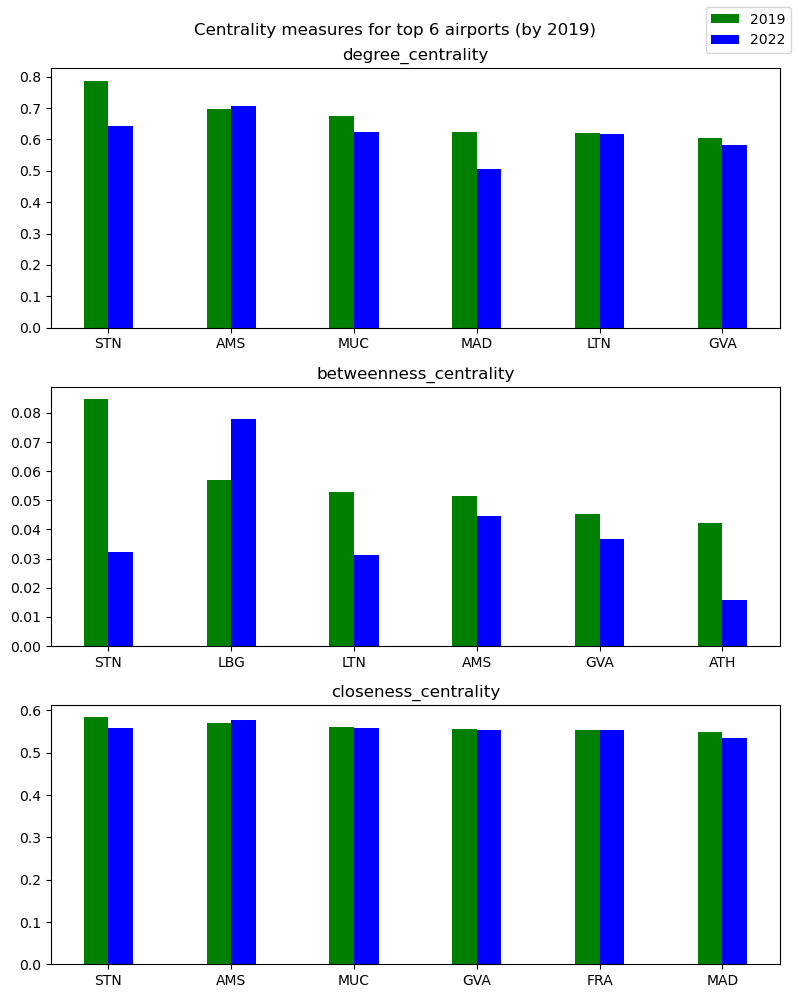

In [104]:
# centrality barplot for top n airports
n = 6
fig, ax = plt.subplots(3,1, figsize= (8,10))
x_axis = np.arange(n)
for i, measure in enumerate(centrality_measures.keys()):
    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i].set_xticks(x_axis, df.index)
    ax[i].set_title(measure)
    
fig.suptitle(f"Centrality measures for top {n} airports (by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  

# Network Density

In [57]:
for year in years:
    print("Network Density in", year, ": ", nx.density(G_directed[year]))

Network Density in 2019 :  0.04351156733568255
Network Density in 2022 :  0.044927244009812815


# Clustering

In [15]:
for year in years:
    print("Average Clustering Coefficient in", year, ": ", nx.average_clustering(G_directed[year]))

Average Clustering Coefficient in 2019 :  0.4266233813054057
Average Clustering Coefficient in 2022 :  0.4754799517484819


# BER Calculations

In [80]:
#Create a dictionary with the berlin Airports
berlin_airports = {}
for year in years:
    berlin_airports[year] = [x for x in routes[year].origin_IATA.loc[routes[year]["origin_city"] == "Berlin"].unique()]

berlin_airports

{'2019': ['SXF', 'TXL'], '2022': ['BER', 'TXL']}

In [81]:
# Clustering Coefficient for BER/SXF
clustering = {}
for year in years:
    clustering[year] = nx.clustering(G_directed[year], berlin_airports[year])

clustering

{'2019': {'SXF': 0.3720659185775465, 'TXL': 0.45971278228458673},
 '2022': {'BER': 0.388972033923174, 'TXL': 0}}

In [82]:
ber_centrality = centrality_values_df.loc[["BER/SXF", "TXL"],:]
ber_centrality

degree_centrality           betweenness_centrality            \
                     2019      2022                   2019      2022   
BER/SXF          0.556851  0.556503               0.026262  0.021166   
TXL              0.393586  0.006397               0.006759  0.000002   

        closeness_centrality            
                        2019      2022  
BER/SXF             0.543582  0.551765  
TXL                 0.508902  0.355842

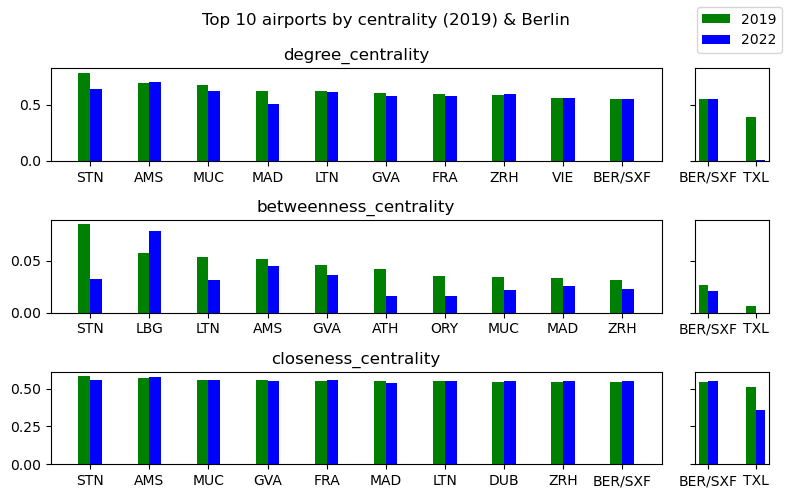

In [92]:
n = 10
fig, ax = plt.subplots(3,2, figsize = (8,5), sharey = "row", gridspec_kw={'width_ratios': [n,1.2]})
x_axis = np.arange(len(ber_centrality))

for i, measure in enumerate(centrality_measures.keys()):
    
    df = ber_centrality[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i,1].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i,1].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i,1].set_xticks(x_axis, df.index)
    #ax[i,1].set_title(measure)
    

x_axis = np.arange(n)
for i, measure in enumerate(centrality_measures.keys()):
    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i, 0].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i, 0].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i, 0].set_xticks(x_axis, df.index)
    ax[i, 0].set_title(measure)
    
fig.suptitle(f"Top {n} airports by centrality (2019) & Berlin")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  
    

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (8,5))
x_axis = np.arange(len(ber_centrality))/4

for i, measure in enumerate(centrality_measures.keys()):
    
    df = ber_centrality[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i].bar(x = x_axis-0.05, height=df["2019"], label = "2019", width = 0.1, color = "green")
    ax[i].bar(x = x_axis+0.05, height=df["2022"], label = "2022", width = 0.1, color = "blue")
    ax[i].set_xticks(x_axis, df.index)
    ax[i].set_title(measure)
    


#
n = 6

x_axis = np.arange(n)
for i, measure in enumerate(centrality_measures.keys()):
    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i].set_xticks(x_axis, df.index)
    ax[i].set_title(measure)
    
fig.suptitle(f"Centrality measures for top {n} airports (by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  

fig.suptitle(f"Centrality measures")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  
    

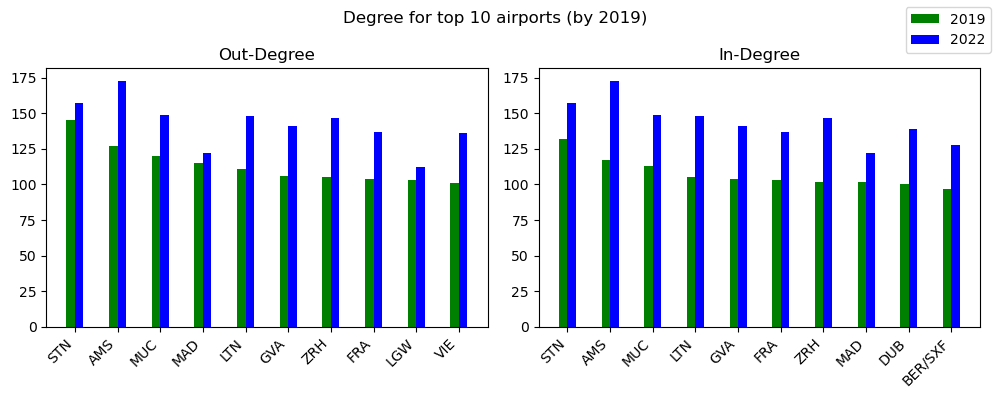

In [58]:
# out-degree barplot for top n aiports

#number of top airports to compare
n = 10
fig, ax = plt.subplots(1,2, figsize= (n,4))
x_axis = np.arange(n)
out_degree = pd.DataFrame.from_dict(out_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

in_degree = pd.DataFrame.from_dict(in_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

out_degree = get_berlin(out_degree)#.loc[["BER/SXF", "TXL"],:]
in_degree = get_berlin(in_degree)#.loc[["BER/SXF", "TXL"],:]

# in_degree.drop(["BER", "SXF", "TXL"], inplace=True)
# out_degree.drop(["BER", "SXF", "TXL"], inplace=True)

x_axis_ber = np.arange(n+1,n+3)

degrees = {"Out-Degree": out_degree.sort_values(ascending = False, by = "2019")[:n], "In-Degree": in_degree.sort_values(ascending = False, by = "2019")[:n]}
#degrees_ber = {"Out-Degree": out_degree_ber, "In-Degree": in_degree_ber}

for number, (name, df) in enumerate(degrees.items()):
    ax[number].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[number].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[number].set_xticks(x_axis, df.index)
    ax[number].set_xticklabels(ax[number].get_xticklabels(), rotation = 45, ha = "right")
    ax[number].set_title(name)

    
# #add Berlin seperately
# for number, (name, df) in enumerate(degrees_ber.items()):
#     ax[number].bar(x = x_axis_ber-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
#     ax[number].bar(x = x_axis_ber+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
#     ax[number].set_title(name)
    
fig.suptitle(f"Degree for top {n} airports (by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  


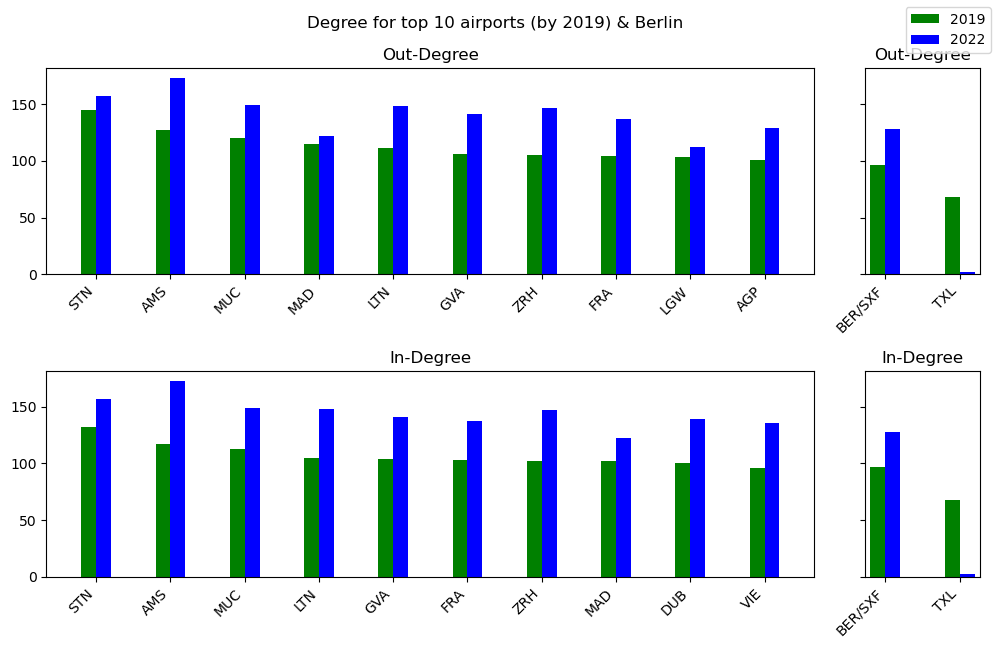

In [78]:
# out-degree barplot for top n aiports

#number of top airports to compare
n = 10
fig, ax = plt.subplots(2,2, figsize= (n,6.5), sharey = True, gridspec_kw={'width_ratios': [n,1.5]})
x_axis = np.arange(n)
out_degree = pd.DataFrame.from_dict(out_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

in_degree = pd.DataFrame.from_dict(in_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

out_degree_ber = get_berlin(out_degree).loc[["BER/SXF", "TXL"],:]
in_degree_ber = get_berlin(in_degree).loc[["BER/SXF", "TXL"],:]

in_degree.drop(["BER", "SXF", "TXL"], inplace=True)
out_degree.drop(["BER", "SXF", "TXL"], inplace=True)

x_axis_ber = np.arange(n+1,n+3)

degrees = {"Out-Degree": out_degree.sort_values(ascending = False, by = "2019")[:n], "In-Degree": in_degree.sort_values(ascending = False, by = "2019")[:n]}
degrees_ber = {"Out-Degree": out_degree_ber, "In-Degree": in_degree_ber}

for number, (name, df) in enumerate(degrees.items()):
    ax[number,0].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[number,0].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[number,0].set_xticks(x_axis, df.index)
    ax[number,0].set_xticklabels(ax[number,0].get_xticklabels(), rotation = 45, ha = "right")
    ax[number,0].set_title(name)

    
#add Berlin seperately
for number, (name, df) in enumerate(degrees_ber.items()):
    ax[number,1].bar(x = x_axis_ber-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[number,1].bar(x = x_axis_ber+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[number,1].set_xticks(x_axis_ber, df.index)
    ax[number,1].set_xticklabels(ax[number,1].get_xticklabels(), rotation = 45, ha = "right")
    ax[number,1].set_title(name)
    
fig.suptitle(f"Degree for top {n} airports (by 2019) & Berlin")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  


In [47]:
out_degree

,2019,2022
BER/SXF,96.0,128.0
TXL,68.0,2.0


In [32]:
out_degree

,2019,2022
AAH,NaN,5.0
AAL,14.0,19.0
AAR,10.0,17.0
ABZ,NaN,37.0
ACH,35.0,37.0
...,...,...
ZMG,3.0,3.0
ZQL,1.0,13.0
ZQW,1.0,11.0
ZRH,105.0,147.0
